In [59]:
import os
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix,f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Reading Data


In [62]:
def load_data(folder):
    data = []
    for filename in os.listdir(folder):
        with open(os.path.join(folder, filename), 'r', encoding='utf-8') as file:
            text = file.read()
            data.append(text)
    return data

In [63]:
pos_data = load_data('/content/drive/MyDrive/pos')
neg_data = load_data('/content/drive/MyDrive/neg')

In [64]:
pos_df = pd.DataFrame({'text': pos_data, 'sentiment': 1})
neg_df = pd.DataFrame({'text': neg_data, 'sentiment': 0})
data = pd.concat([pos_df, neg_df], ignore_index=True)
data

,text,sentiment
0,films adapted from comic books have had plenty...,1
1,every now and then a movie comes along from a ...,1
2,you've got mail works alot better than it dese...,1
3,""" jaws "" is a rare film that grabs your atten...",1
4,moviemaking is a lot like being the general ma...,1
...,...,...
1995,"if anything , "" stigmata "" should be taken as ...",0
1996,"john boorman's "" zardoz "" is a goofy cinematic...",0
1997,the kids in the hall are an acquired taste . \...,0
1998,there was a time when john carpenter was a gre...,0


#### Shuffle rows

In [65]:
shuffled_data = data.sample(frac=1,random_state=300).reset_index(drop=True)
shuffled_data

,text,sentiment
0,""" the endurance : shackleton's legendary anta...",1
1,imagine this . \nyou're given a sword and a sh...,1
2,"in some respects , rush hour is the ultimate e...",1
3,""" you leave little notes on my pillow . \ni t...",1
4,is evil dead ii a bad movie ? \nit's full of t...,1
...,...,...
1995,it is movies like these that make a jaded movi...,0
1996,well if you are up for stellar effects then th...,0
1997,plot : a dude and his brother are driving cros...,1
1998,"apocalypse now , based on the novel "" hearts o...",1


### Preprocessing

In [66]:
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = ''.join([i for i in text if not i.isdigit()])
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

In [67]:
X = shuffled_data['text'].apply(preprocess_text)
y = shuffled_data['sentiment']
#y.to_csv("shuff.csv",index=False)
y

0       1
1       1
2       1
3       1
4       1
       ..
1995    0
1996    0
1997    1
1998    1
1999    0
Name: sentiment, Length: 2000, dtype: int64

### Plotting

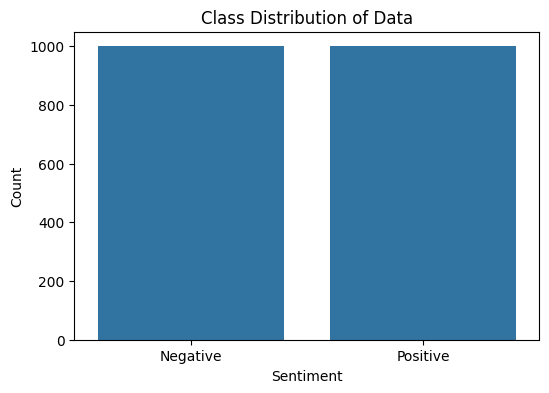

In [68]:
# Count of Positive and Negative Classes
class_counts = y.value_counts()

# Plotting
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution of Data')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()

### Splitting Train and Test

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Label encoding

In [70]:
# Label encoding
label_encoder = LabelEncoder()
train_y = label_encoder.fit_transform(y_train)
test_y = label_encoder.fit_transform(y_test)

#### TFiDf

In [71]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

### Multinomial Naive Bayes

In [72]:
# Model training Naive Bayes
model = MultinomialNB()
model.fit(tfidf_train, y_train)

MultinomialNB()

In [73]:
y_pred = model.predict(tfidf_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("F1 Score:", f1)
print("Naive Bayes Accuracy:", accuracy)

F1 Score: 0.8282828282828282
Naive Bayes Accuracy: 0.83


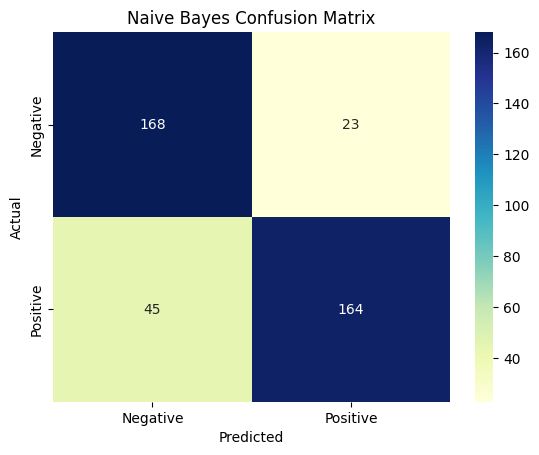

In [74]:
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="YlGnBu", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Naive Bayes Confusion Matrix')
plt.show()

### SVM

In [75]:
C=3
linear_svc = svm.SVC(kernel='linear', C=C).fit(tfidf_train, y_train)
rbf_svc = svm.SVC(kernel='rbf', gamma=0.8, C=C).fit(tfidf_train, train_y)


In [76]:
y_pred = rbf_svc.predict(tfidf_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("F1 Score:", f1)
print(" RBF Accuracy:", accuracy)

F1 Score: 0.8571428571428572
 RBF Accuracy: 0.855


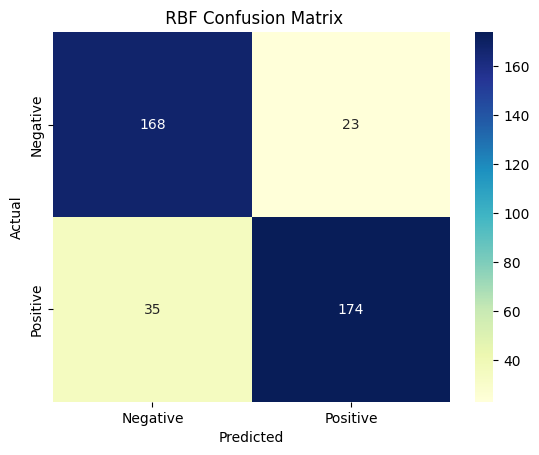

In [77]:
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="YlGnBu", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(' RBF Confusion Matrix')
plt.show()

In [78]:
y_pred = linear_svc.predict(tfidf_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("F1 Score:", f1)
print("linear svm Accuracy:", accuracy)

F1 Score: 0.8493827160493828
linear svm Accuracy: 0.8475


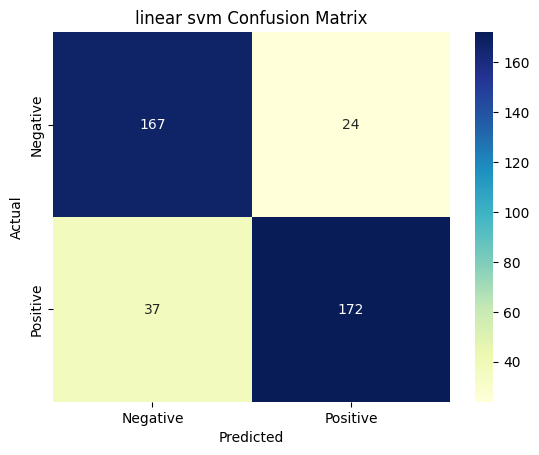

In [79]:
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="YlGnBu", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('linear svm Confusion Matrix')
plt.show()

In [80]:
# # x = dataframe['sentiment']
# labels = ['Negative', 'Positive']

# plt.xlabel('Polarity')
# plt.ylabel('Data Points')
# plt.title("Polarity Distribution")
# plt.hist(X)
# plt.xticks(X, labels, rotation='vertical')
# #plt.xticks(np.arange(0,2,1), labels, rotation='vertical')
# plt.grid(True)
# plt.show()

# **Random Forest**

In [81]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

rf_classifier = RandomForestClassifier(n_estimators=250, random_state=44)
rf_classifier.fit(tfidf_train, y_train)
y_pred = rf_classifier.predict(tfidf_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)
print("Random Forest Accuracy:", accuracy)


F1 Score: 0.8217054263565892
Random Forest Accuracy: 0.8275


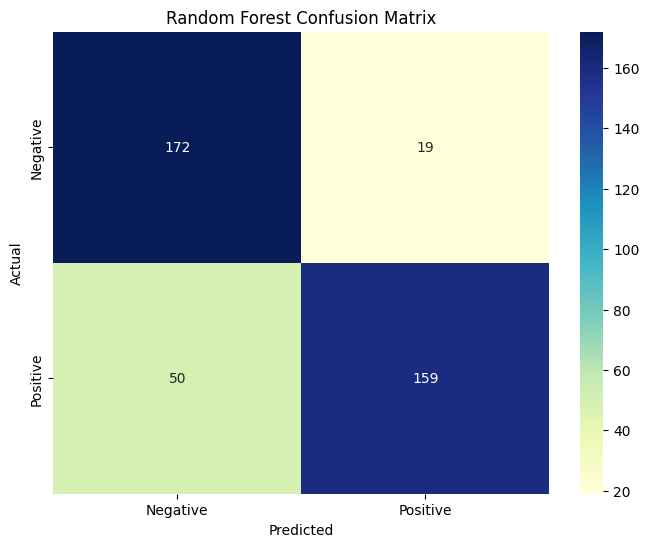

In [82]:
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="YlGnBu", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()


## **Logistic Regression**

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

logistic_classifier = LogisticRegression(random_state=50)
logistic_classifier.fit(tfidf_train, y_train)
y_pred = logistic_classifier.predict(tfidf_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary')
print("F1 Score:", f1)
print("Logistic Regression Accuracy:", accuracy)


F1 Score: 0.861244019138756
Logistic Regression Accuracy: 0.855


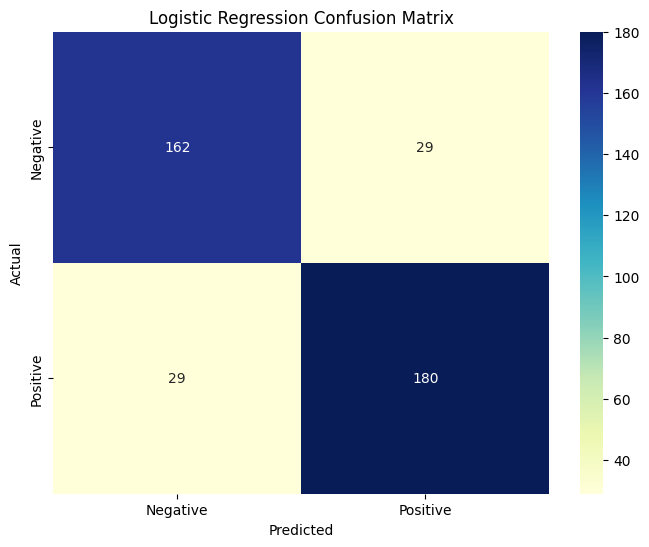

In [84]:
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="YlGnBu", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')
plt.show()


## **Word cloud**

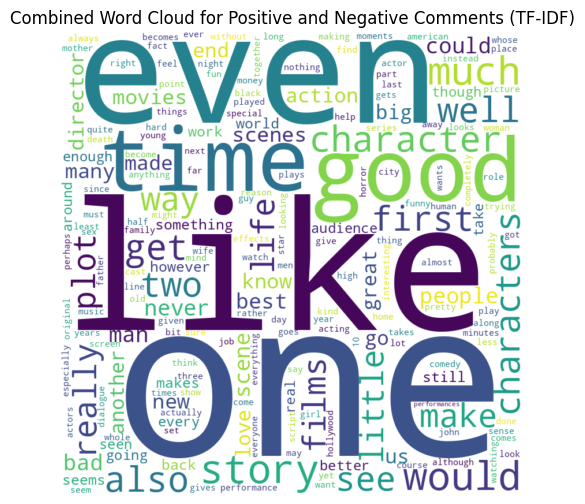

In [99]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

# Define custom stop words
custom_stop_words = ['film', 'movie', 'cinema']

# Concatenate positive and negative comments
all_comments = ' '.join(pos_data + neg_data)

# Get NLTK stopwords
stop_words = set(stopwords.words('english'))

# Initialize TfidfVectorizer with custom stop words
tfidf_vectorizer = TfidfVectorizer(stop_words=list(stop_words.union(custom_stop_words)))

# Fit and transform all comments
tfidf_all = tfidf_vectorizer.fit_transform([all_comments])

# Get feature names (words)
feature_names_all = tfidf_vectorizer.get_feature_names_out()

# Get TF-IDF scores for all comments
tfidf_scores_all = tfidf_all.sum(axis=0).A1

# Combine feature names and TF-IDF scores into a dictionary
word_scores_all = dict(zip(feature_names_all, tfidf_scores_all))

# Generate word cloud for all comments
wordcloud_all = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies(word_scores_all)

# Plot word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.title('Combined Word Cloud for Positive and Negative Comments (TF-IDF)')
plt.axis('off')
plt.show()
